**Q1: Explain the minimax loss function in GANs and how it ensures competitive training between the generator and discriminator.**

The minimax loss function creates a game where the generator and discriminator compete against each other.  The generator attempts to minimize the loss, while the discriminator attempts to maximize it.  In this way, the two models compete against each other and learn simultaneously.  Both models use the fake generated data to calculate the gradients and perform backpropagation, so as the discriminator learns to better distinguish between real and fake images, it forces the generator to learn to generate better images.

**Q2: What is mode collapse, Why can mode collapse occur during GAN training? and how can it be mitigated?**

Mode collapse occurs when the generator converges on one type of image and generates similar images.  In this way, it fails to capture the diversity of the true dataset and does not generate a variety of images representative of the true distribution.  Several approaches can be used to mitigate mode collapse, such as dropout, adding Gaussian noise to input data, or using variant architecture such as Wasserstein GAN (WGAN) which uses Wasserstein distance and may introduce gradient penalties.

**Q3: Explain the role of the discriminator in adversarial training?**

The discriminator serves as the classifier in this problem, seeking to differentiate real from fake data.  It is important that it is trained at a similar pace to the generator, however, so that the generator can still learn something.  The discriminator therefore needs to learn how to differentiate the images over time, initially just guessing which is which and quickly learning the patterns and shapes of the true distribution so that the generator can seek to close that gap and more closely model that true distribution.

**Q4: How do metrics like IS and FID evaluate GAN performance?**

Inception Score (IS) is used to automatically score the quality of a simulated image using a pre-trained Inception v3 Network classifier that outputs the probability of a class.  Using the confidence and KL divergence, the metric is able to accurately rate the quality of a generated image similar to human evaluations.

Frechet Inception Distance (FID) also uses a pre-trained Inception v3 model to calculate the distance between the real and fake feature vectors using their mean and covariance.

Both of these metrics are useful for evaluating GAN performance because they closely replicate and automate human scoring of images.  Metrics such as accuracy obviously do not work with content generation, so oftentimes human evaluation is required.  These metrics automate this human evaluation using pre-trained models to accurate assess the quality of the generated images from the GAN for comparing different architectures and performances.

In [1]:
import tensorflow as tf
from tensorflow.keras import layers

In [2]:
# Load and preprocess data
(train_images, _), (_, _) = tf.keras.datasets.cifar10.load_data()
train_images = train_images.reshape(-1, 32, 32, 3).astype('float32')
train_images = (train_images - 127.5) / 127.5 # Normalize to [-1, 1]

BUFFER_SIZE = 60000
BATCH_SIZE = 256
train_dataset = (
    tf.data.Dataset
    .from_tensor_slices(train_images)
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
)

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step


In [3]:
# Generator model
def make_generator_model(latent_size=100):
    model = tf.keras.Sequential([
        layers.Dense(2*2*512, use_bias=False, input_shape=(latent_size,)),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        layers.Reshape((2, 2, 512)),
        layers.Conv2D(512, (3, 3), strides=(1, 1), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        layers.Conv2DTranspose(256, (5, 5), strides=(1, 1), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        layers.Conv2DTranspose(32, (5, 5), strides=(2, 2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh')
    ])
    return model

# Discriminator model
def make_discriminator_model():
    model = tf.keras.Sequential([
        layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[32, 32, 3]),
        layers.LeakyReLU(),
        layers.Dropout(0.3),
        layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'),
        layers.LeakyReLU(),
        layers.Dropout(0.3),
        layers.Flatten(),
        layers.Dense(1)
        ])
    return model

In [4]:
# Loss functions
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    return real_loss + fake_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [5]:
# Hyperparameters
latent_size = 100
lr = 1e-4
epochs = 200

In [6]:
# Optimizers
generator = make_generator_model(latent_size=latent_size)
discriminator = make_discriminator_model()
generator_optimizer = tf.keras.optimizers.Adam(lr)
discriminator_optimizer = tf.keras.optimizers.Adam(lr)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [7]:
# Training function
@tf.function
def train_step(images, latent_size):
    noise = tf.random.normal([BATCH_SIZE, latent_size])
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss

# Training loop
def train(dataset, epochs, latent_size=100):
    # Track loss per epoch to graph
    gen_losses = []
    disc_losses = []
    for epoch in range(epochs):
        # Average batch loss over epoch
        batch_count = 0
        avg_gen_loss = 0
        avg_disc_loss = 0
        for image_batch in dataset:
            gen_loss, disc_loss = train_step(image_batch, latent_size=latent_size)
            avg_gen_loss += gen_loss
            avg_disc_loss += disc_loss
            batch_count += 1

        avg_gen_loss /= batch_count
        avg_disc_loss /= batch_count
        gen_losses.append(avg_gen_loss)
        disc_losses.append(avg_disc_loss)
        print(f"Epoch {epoch + 1} completed. Generator Loss: {avg_gen_loss}\tDiscriminator Loss: {avg_disc_loss}")

        # Save images every 10 epochs
        if (epoch + 1) % 10 == 0:
            generate_images(generator, epoch + 1, num_images=5, save=True)

    return gen_losses, disc_losses

In [8]:
print(train_images.shape)

(50000, 32, 32, 3)


Epoch 1 completed. Generator Loss: 1.097348928451538	Discriminator Loss: 1.2857903242111206
Epoch 2 completed. Generator Loss: 1.2421990633010864	Discriminator Loss: 1.1124579906463623
Epoch 3 completed. Generator Loss: 1.1506718397140503	Discriminator Loss: 1.121107578277588
Epoch 4 completed. Generator Loss: 1.1342227458953857	Discriminator Loss: 1.2264049053192139
Epoch 5 completed. Generator Loss: 1.1478458642959595	Discriminator Loss: 1.3515911102294922
Epoch 6 completed. Generator Loss: 1.1341500282287598	Discriminator Loss: 1.2855424880981445
Epoch 7 completed. Generator Loss: 1.0957484245300293	Discriminator Loss: 1.319806456565857
Epoch 8 completed. Generator Loss: 1.1683121919631958	Discriminator Loss: 1.201033592224121
Epoch 9 completed. Generator Loss: 1.1878972053527832	Discriminator Loss: 1.284556269645691
Epoch 10 completed. Generator Loss: 1.2766788005828857	Discriminator Loss: 1.1942371129989624


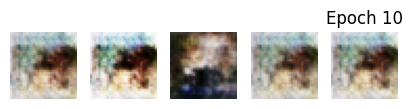

Epoch 11 completed. Generator Loss: 1.164833664894104	Discriminator Loss: 1.2467310428619385
Epoch 12 completed. Generator Loss: 1.2618745565414429	Discriminator Loss: 1.1776138544082642
Epoch 13 completed. Generator Loss: 1.3691723346710205	Discriminator Loss: 0.9998464584350586
Epoch 14 completed. Generator Loss: 1.1578431129455566	Discriminator Loss: 1.2629743814468384
Epoch 15 completed. Generator Loss: 1.222405195236206	Discriminator Loss: 1.1482454538345337
Epoch 16 completed. Generator Loss: 1.2700598239898682	Discriminator Loss: 1.1444708108901978
Epoch 17 completed. Generator Loss: 1.2432892322540283	Discriminator Loss: 1.1658124923706055
Epoch 18 completed. Generator Loss: 1.1963629722595215	Discriminator Loss: 1.210574984550476
Epoch 19 completed. Generator Loss: 1.2434381246566772	Discriminator Loss: 1.1367130279541016
Epoch 20 completed. Generator Loss: 1.2474279403686523	Discriminator Loss: 1.1287877559661865


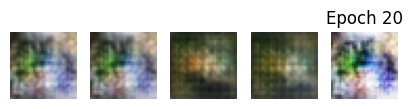

Epoch 21 completed. Generator Loss: 1.2506555318832397	Discriminator Loss: 1.117845058441162
Epoch 22 completed. Generator Loss: 1.2997249364852905	Discriminator Loss: 1.0869317054748535
Epoch 23 completed. Generator Loss: 1.2673250436782837	Discriminator Loss: 1.0711162090301514
Epoch 24 completed. Generator Loss: 1.2675933837890625	Discriminator Loss: 1.1818538904190063
Epoch 25 completed. Generator Loss: 1.4220271110534668	Discriminator Loss: 1.1127265691757202
Epoch 26 completed. Generator Loss: 1.3429876565933228	Discriminator Loss: 1.0831032991409302
Epoch 27 completed. Generator Loss: 1.3944083452224731	Discriminator Loss: 1.0354489088058472
Epoch 28 completed. Generator Loss: 1.2439446449279785	Discriminator Loss: 1.2254137992858887
Epoch 29 completed. Generator Loss: 1.2834502458572388	Discriminator Loss: 1.0719897747039795
Epoch 30 completed. Generator Loss: 1.2913269996643066	Discriminator Loss: 1.1577202081680298


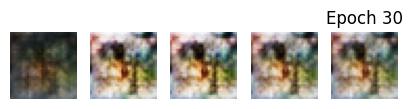

Epoch 31 completed. Generator Loss: 1.3581676483154297	Discriminator Loss: 1.0638507604599
Epoch 32 completed. Generator Loss: 1.260801076889038	Discriminator Loss: 1.1477075815200806
Epoch 33 completed. Generator Loss: 1.1751577854156494	Discriminator Loss: 1.1582894325256348
Epoch 34 completed. Generator Loss: 1.2177892923355103	Discriminator Loss: 1.2286367416381836
Epoch 35 completed. Generator Loss: 1.375470519065857	Discriminator Loss: 1.1419826745986938
Epoch 36 completed. Generator Loss: 1.3163548707962036	Discriminator Loss: 1.3389759063720703
Epoch 37 completed. Generator Loss: 1.2636674642562866	Discriminator Loss: 1.3257731199264526
Epoch 38 completed. Generator Loss: 1.284835934638977	Discriminator Loss: 1.176400899887085
Epoch 39 completed. Generator Loss: 1.2664791345596313	Discriminator Loss: 1.1222481727600098
Epoch 40 completed. Generator Loss: 1.3656415939331055	Discriminator Loss: 1.050806999206543


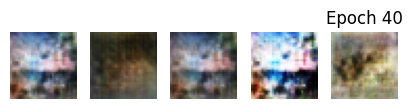

Epoch 41 completed. Generator Loss: 1.2077451944351196	Discriminator Loss: 1.2121751308441162
Epoch 42 completed. Generator Loss: 1.2596485614776611	Discriminator Loss: 1.1652923822402954
Epoch 43 completed. Generator Loss: 1.2009799480438232	Discriminator Loss: 1.1957396268844604
Epoch 44 completed. Generator Loss: 1.3377684354782104	Discriminator Loss: 1.0826590061187744
Epoch 45 completed. Generator Loss: 1.3098617792129517	Discriminator Loss: 1.0596307516098022
Epoch 46 completed. Generator Loss: 1.2137808799743652	Discriminator Loss: 1.2025634050369263
Epoch 47 completed. Generator Loss: 1.18134605884552	Discriminator Loss: 1.231951355934143
Epoch 48 completed. Generator Loss: 1.318772315979004	Discriminator Loss: 1.0925904512405396
Epoch 49 completed. Generator Loss: 1.2351319789886475	Discriminator Loss: 1.114382266998291
Epoch 50 completed. Generator Loss: 1.2593703269958496	Discriminator Loss: 1.2226159572601318


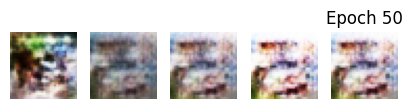

Epoch 51 completed. Generator Loss: 1.2508304119110107	Discriminator Loss: 1.4044511318206787
Epoch 52 completed. Generator Loss: 1.2695609331130981	Discriminator Loss: 1.2236406803131104
Epoch 53 completed. Generator Loss: 1.2224721908569336	Discriminator Loss: 1.196771502494812
Epoch 54 completed. Generator Loss: 1.3164511919021606	Discriminator Loss: 1.2375603914260864
Epoch 55 completed. Generator Loss: 1.2505956888198853	Discriminator Loss: 1.1391088962554932
Epoch 56 completed. Generator Loss: 1.243623971939087	Discriminator Loss: 1.0953983068466187
Epoch 57 completed. Generator Loss: 1.1822640895843506	Discriminator Loss: 1.1900156736373901
Epoch 58 completed. Generator Loss: 1.2099974155426025	Discriminator Loss: 1.163173794746399
Epoch 59 completed. Generator Loss: 1.2413687705993652	Discriminator Loss: 1.153989553451538
Epoch 60 completed. Generator Loss: 1.217495322227478	Discriminator Loss: 1.2332123517990112


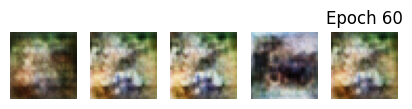

Epoch 61 completed. Generator Loss: 1.2382196187973022	Discriminator Loss: 1.1618605852127075
Epoch 62 completed. Generator Loss: 1.2937244176864624	Discriminator Loss: 1.1438580751419067
Epoch 63 completed. Generator Loss: 1.3221222162246704	Discriminator Loss: 1.0947179794311523
Epoch 64 completed. Generator Loss: 1.252566933631897	Discriminator Loss: 1.2131162881851196
Epoch 65 completed. Generator Loss: 1.187495231628418	Discriminator Loss: 1.1891371011734009
Epoch 66 completed. Generator Loss: 1.2495840787887573	Discriminator Loss: 1.2463009357452393
Epoch 67 completed. Generator Loss: 1.2003692388534546	Discriminator Loss: 1.162273645401001
Epoch 68 completed. Generator Loss: 1.2429574728012085	Discriminator Loss: 1.1492061614990234
Epoch 69 completed. Generator Loss: 1.2072852849960327	Discriminator Loss: 1.2249517440795898
Epoch 70 completed. Generator Loss: 1.2081575393676758	Discriminator Loss: 1.2052741050720215


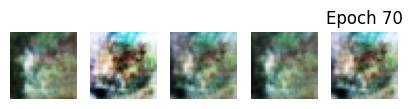

Epoch 71 completed. Generator Loss: 1.2552977800369263	Discriminator Loss: 1.2394012212753296
Epoch 72 completed. Generator Loss: 1.2674870491027832	Discriminator Loss: 1.1939458847045898
Epoch 73 completed. Generator Loss: 1.2885085344314575	Discriminator Loss: 1.1798820495605469
Epoch 74 completed. Generator Loss: 1.2256110906600952	Discriminator Loss: 1.3614192008972168
Epoch 75 completed. Generator Loss: 1.2057900428771973	Discriminator Loss: 1.3662422895431519
Epoch 76 completed. Generator Loss: 1.2852236032485962	Discriminator Loss: 1.0379374027252197
Epoch 77 completed. Generator Loss: 1.246113657951355	Discriminator Loss: 1.1504502296447754
Epoch 78 completed. Generator Loss: 1.177456021308899	Discriminator Loss: 1.2047791481018066
Epoch 79 completed. Generator Loss: 1.1985664367675781	Discriminator Loss: 1.1872905492782593
Epoch 80 completed. Generator Loss: 1.224125862121582	Discriminator Loss: 1.2712820768356323


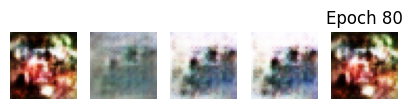

Epoch 81 completed. Generator Loss: 1.338526964187622	Discriminator Loss: 1.1747630834579468
Epoch 82 completed. Generator Loss: 1.3513518571853638	Discriminator Loss: 1.0903785228729248
Epoch 83 completed. Generator Loss: 1.3051280975341797	Discriminator Loss: 1.0449151992797852
Epoch 84 completed. Generator Loss: 1.3511234521865845	Discriminator Loss: 1.1436808109283447
Epoch 85 completed. Generator Loss: 1.2519207000732422	Discriminator Loss: 1.2304941415786743
Epoch 86 completed. Generator Loss: 1.174094319343567	Discriminator Loss: 1.225977897644043
Epoch 87 completed. Generator Loss: 1.1767905950546265	Discriminator Loss: 1.2970200777053833
Epoch 88 completed. Generator Loss: 1.2682459354400635	Discriminator Loss: 1.0911550521850586
Epoch 89 completed. Generator Loss: 1.33612859249115	Discriminator Loss: 1.060012698173523
Epoch 90 completed. Generator Loss: 1.2509865760803223	Discriminator Loss: 1.2013193368911743


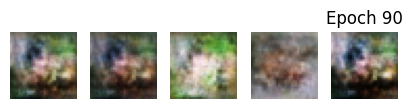

Epoch 91 completed. Generator Loss: 1.1960067749023438	Discriminator Loss: 1.248305082321167
Epoch 92 completed. Generator Loss: 1.2274004220962524	Discriminator Loss: 1.2002630233764648
Epoch 93 completed. Generator Loss: 1.2326205968856812	Discriminator Loss: 1.1338502168655396
Epoch 94 completed. Generator Loss: 1.2159792184829712	Discriminator Loss: 1.1075072288513184
Epoch 95 completed. Generator Loss: 1.2556380033493042	Discriminator Loss: 1.2410719394683838
Epoch 96 completed. Generator Loss: 1.4948889017105103	Discriminator Loss: 1.1279727220535278
Epoch 97 completed. Generator Loss: 1.3338953256607056	Discriminator Loss: 1.1393450498580933
Epoch 98 completed. Generator Loss: 1.3610342741012573	Discriminator Loss: 1.1120901107788086
Epoch 99 completed. Generator Loss: 1.298500418663025	Discriminator Loss: 1.0852713584899902
Epoch 100 completed. Generator Loss: 1.3262734413146973	Discriminator Loss: 0.9914944767951965


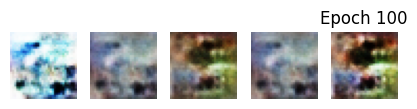

Epoch 101 completed. Generator Loss: 1.3545124530792236	Discriminator Loss: 1.2871496677398682
Epoch 102 completed. Generator Loss: 1.1717634201049805	Discriminator Loss: 1.3605966567993164
Epoch 103 completed. Generator Loss: 1.2317756414413452	Discriminator Loss: 1.1962515115737915
Epoch 104 completed. Generator Loss: 1.301893711090088	Discriminator Loss: 1.0973013639450073
Epoch 105 completed. Generator Loss: 1.197704553604126	Discriminator Loss: 1.2018580436706543
Epoch 106 completed. Generator Loss: 1.2992554903030396	Discriminator Loss: 1.1592015027999878
Epoch 107 completed. Generator Loss: 1.2929390668869019	Discriminator Loss: 1.1793980598449707
Epoch 108 completed. Generator Loss: 1.355288028717041	Discriminator Loss: 1.1582022905349731
Epoch 109 completed. Generator Loss: 1.257896065711975	Discriminator Loss: 1.215364694595337
Epoch 110 completed. Generator Loss: 1.3004158735275269	Discriminator Loss: 1.1541459560394287


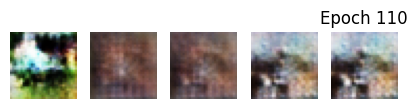

Epoch 111 completed. Generator Loss: 1.3626155853271484	Discriminator Loss: 1.0942323207855225
Epoch 112 completed. Generator Loss: 1.238369107246399	Discriminator Loss: 1.2620134353637695
Epoch 113 completed. Generator Loss: 1.1839046478271484	Discriminator Loss: 1.2310036420822144
Epoch 114 completed. Generator Loss: 1.184635043144226	Discriminator Loss: 1.148187279701233
Epoch 115 completed. Generator Loss: 1.2308752536773682	Discriminator Loss: 1.157498836517334
Epoch 116 completed. Generator Loss: 1.2070634365081787	Discriminator Loss: 1.1849918365478516
Epoch 117 completed. Generator Loss: 1.2791444063186646	Discriminator Loss: 1.1115392446517944
Epoch 118 completed. Generator Loss: 1.2756402492523193	Discriminator Loss: 1.154935598373413
Epoch 119 completed. Generator Loss: 1.1588127613067627	Discriminator Loss: 1.3333170413970947
Epoch 120 completed. Generator Loss: 1.282869815826416	Discriminator Loss: 1.3488692045211792


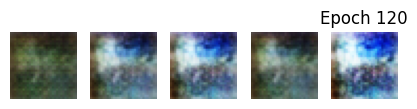

Epoch 121 completed. Generator Loss: 1.2157602310180664	Discriminator Loss: 1.1890887022018433
Epoch 122 completed. Generator Loss: 1.1919656991958618	Discriminator Loss: 1.2485586404800415
Epoch 123 completed. Generator Loss: 1.2408909797668457	Discriminator Loss: 1.1135003566741943
Epoch 124 completed. Generator Loss: 1.2458264827728271	Discriminator Loss: 1.1553325653076172
Epoch 125 completed. Generator Loss: 1.2694443464279175	Discriminator Loss: 1.2185792922973633
Epoch 126 completed. Generator Loss: 1.3069889545440674	Discriminator Loss: 1.1393177509307861
Epoch 127 completed. Generator Loss: 1.2547630071640015	Discriminator Loss: 1.2172987461090088
Epoch 128 completed. Generator Loss: 1.337990641593933	Discriminator Loss: 1.0890229940414429
Epoch 129 completed. Generator Loss: 1.3211129903793335	Discriminator Loss: 1.0780632495880127
Epoch 130 completed. Generator Loss: 1.304247498512268	Discriminator Loss: 1.1038761138916016


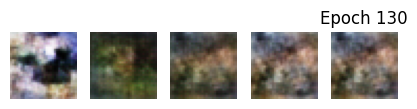

Epoch 131 completed. Generator Loss: 1.235219955444336	Discriminator Loss: 1.2513560056686401
Epoch 132 completed. Generator Loss: 1.3197402954101562	Discriminator Loss: 1.0806962251663208
Epoch 133 completed. Generator Loss: 1.2302846908569336	Discriminator Loss: 1.1419974565505981
Epoch 134 completed. Generator Loss: 1.275664210319519	Discriminator Loss: 1.1300379037857056
Epoch 135 completed. Generator Loss: 1.2630670070648193	Discriminator Loss: 1.201708436012268
Epoch 136 completed. Generator Loss: 1.231041431427002	Discriminator Loss: 1.2370001077651978
Epoch 137 completed. Generator Loss: 1.400360107421875	Discriminator Loss: 1.135115146636963
Epoch 138 completed. Generator Loss: 1.3924068212509155	Discriminator Loss: 1.1963841915130615
Epoch 139 completed. Generator Loss: 1.2566295862197876	Discriminator Loss: 1.252317190170288
Epoch 140 completed. Generator Loss: 1.334226369857788	Discriminator Loss: 1.1241766214370728


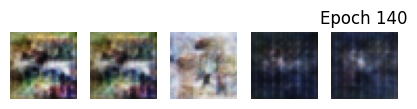

Epoch 141 completed. Generator Loss: 1.25308358669281	Discriminator Loss: 1.141202449798584
Epoch 142 completed. Generator Loss: 1.2331618070602417	Discriminator Loss: 1.1292142868041992
Epoch 143 completed. Generator Loss: 1.3370213508605957	Discriminator Loss: 1.1011083126068115
Epoch 144 completed. Generator Loss: 1.2654269933700562	Discriminator Loss: 1.2668180465698242
Epoch 145 completed. Generator Loss: 1.2192002534866333	Discriminator Loss: 1.2582225799560547
Epoch 146 completed. Generator Loss: 1.2304251194000244	Discriminator Loss: 1.2080469131469727
Epoch 147 completed. Generator Loss: 1.2500927448272705	Discriminator Loss: 1.1092777252197266
Epoch 148 completed. Generator Loss: 1.1923388242721558	Discriminator Loss: 1.1567399501800537
Epoch 149 completed. Generator Loss: 1.2429659366607666	Discriminator Loss: 1.1165345907211304
Epoch 150 completed. Generator Loss: 1.172306776046753	Discriminator Loss: 1.255263328552246


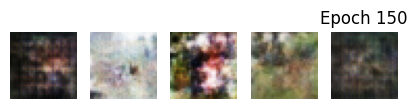

Epoch 151 completed. Generator Loss: 1.2297961711883545	Discriminator Loss: 1.1734788417816162
Epoch 152 completed. Generator Loss: 1.4170688390731812	Discriminator Loss: 1.0524252653121948
Epoch 153 completed. Generator Loss: 1.2731263637542725	Discriminator Loss: 1.1225963830947876
Epoch 154 completed. Generator Loss: 1.2595394849777222	Discriminator Loss: 1.1305586099624634
Epoch 155 completed. Generator Loss: 1.314171314239502	Discriminator Loss: 1.1040396690368652
Epoch 156 completed. Generator Loss: 1.2578405141830444	Discriminator Loss: 1.2662622928619385
Epoch 157 completed. Generator Loss: 1.3875318765640259	Discriminator Loss: 1.0107446908950806
Epoch 158 completed. Generator Loss: 1.412156343460083	Discriminator Loss: 1.08124840259552
Epoch 159 completed. Generator Loss: 1.37517511844635	Discriminator Loss: 1.1180791854858398
Epoch 160 completed. Generator Loss: 1.3203431367874146	Discriminator Loss: 1.140994668006897


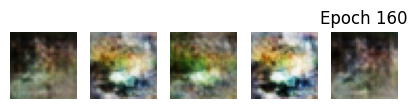

Epoch 161 completed. Generator Loss: 1.3594772815704346	Discriminator Loss: 1.0867310762405396
Epoch 162 completed. Generator Loss: 1.51253342628479	Discriminator Loss: 1.047205924987793
Epoch 163 completed. Generator Loss: 1.2871084213256836	Discriminator Loss: 1.1520936489105225
Epoch 164 completed. Generator Loss: 1.2037746906280518	Discriminator Loss: 1.1992835998535156
Epoch 165 completed. Generator Loss: 1.1849480867385864	Discriminator Loss: 1.22548508644104
Epoch 166 completed. Generator Loss: 1.2474135160446167	Discriminator Loss: 1.1524018049240112
Epoch 167 completed. Generator Loss: 1.3549280166625977	Discriminator Loss: 1.1125494241714478
Epoch 168 completed. Generator Loss: 1.423134207725525	Discriminator Loss: 1.1772794723510742
Epoch 169 completed. Generator Loss: 1.2906625270843506	Discriminator Loss: 1.2116320133209229
Epoch 170 completed. Generator Loss: 1.3558685779571533	Discriminator Loss: 1.0150202512741089


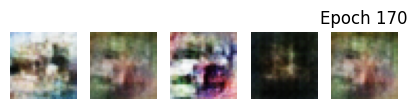

Epoch 171 completed. Generator Loss: 1.307165503501892	Discriminator Loss: 1.0246570110321045
Epoch 172 completed. Generator Loss: 1.3483994007110596	Discriminator Loss: 1.158143162727356
Epoch 173 completed. Generator Loss: 1.2843550443649292	Discriminator Loss: 1.170479655265808
Epoch 174 completed. Generator Loss: 1.1777595281600952	Discriminator Loss: 1.3033080101013184
Epoch 175 completed. Generator Loss: 1.3940690755844116	Discriminator Loss: 1.1433207988739014
Epoch 176 completed. Generator Loss: 1.339167833328247	Discriminator Loss: 1.2299470901489258
Epoch 177 completed. Generator Loss: 1.2591217756271362	Discriminator Loss: 1.2268325090408325
Epoch 178 completed. Generator Loss: 1.1894710063934326	Discriminator Loss: 1.176712989807129
Epoch 179 completed. Generator Loss: 1.145654559135437	Discriminator Loss: 1.2711973190307617
Epoch 180 completed. Generator Loss: 1.2246557474136353	Discriminator Loss: 1.2081931829452515


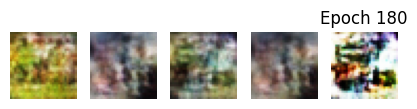

Epoch 181 completed. Generator Loss: 1.3125202655792236	Discriminator Loss: 1.253727912902832
Epoch 182 completed. Generator Loss: 1.3950022459030151	Discriminator Loss: 1.0894855260849
Epoch 183 completed. Generator Loss: 1.4330018758773804	Discriminator Loss: 1.0503120422363281
Epoch 184 completed. Generator Loss: 1.3117122650146484	Discriminator Loss: 1.2135075330734253
Epoch 185 completed. Generator Loss: 1.3485602140426636	Discriminator Loss: 1.1149373054504395
Epoch 186 completed. Generator Loss: 1.292362093925476	Discriminator Loss: 1.0835371017456055
Epoch 187 completed. Generator Loss: 1.196435809135437	Discriminator Loss: 1.1925177574157715
Epoch 188 completed. Generator Loss: 1.252561092376709	Discriminator Loss: 1.2146190404891968
Epoch 189 completed. Generator Loss: 1.2374907732009888	Discriminator Loss: 1.2422221899032593
Epoch 190 completed. Generator Loss: 1.3201664686203003	Discriminator Loss: 1.1146506071090698


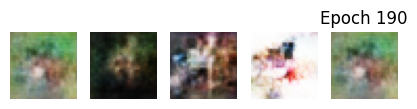

Epoch 191 completed. Generator Loss: 1.2495442628860474	Discriminator Loss: 1.1799348592758179
Epoch 192 completed. Generator Loss: 1.2886931896209717	Discriminator Loss: 1.1238915920257568
Epoch 193 completed. Generator Loss: 1.315659761428833	Discriminator Loss: 1.0748709440231323
Epoch 194 completed. Generator Loss: 1.3517791032791138	Discriminator Loss: 1.0227982997894287
Epoch 195 completed. Generator Loss: 1.378191590309143	Discriminator Loss: 1.108717679977417
Epoch 196 completed. Generator Loss: 1.3762197494506836	Discriminator Loss: 1.0589765310287476
Epoch 197 completed. Generator Loss: 1.222062587738037	Discriminator Loss: 1.2102038860321045
Epoch 198 completed. Generator Loss: 1.3200021982192993	Discriminator Loss: 1.128199815750122
Epoch 199 completed. Generator Loss: 1.336276888847351	Discriminator Loss: 1.1675810813903809
Epoch 200 completed. Generator Loss: 1.2745846509933472	Discriminator Loss: 1.2305400371551514


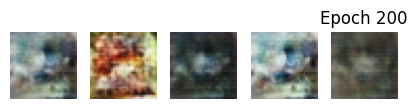

In [15]:
# Run the training
gen_losses, disc_losses = train(train_dataset, epochs=epochs)

In [12]:
generator.save_weights('generator_400.weights.h5')
discriminator.save_weights('discriminator_400.weights.h5')

## Analysis
Image saving after every 10 epochs was implemented to track the generator progress.  We can see the generator slowly progressing to more detailed and diverse images.  On the 200th epoch, the generator performs somewhat well, while the discriminator and generator loss are somewhat balanced.  We can also graph the loss for both models over each epoch to see what it looks like over time.

In [9]:
# Function to generate images with a trained model
import matplotlib.pyplot as plt
def generate_images(model, epoch, num_images=5, latent_size=100, plot=True, save=False):
  noise = tf.random.normal([num_images, latent_size])
  generated_images = model(noise, training=False)

  # Rescale to [0, 255]
  generated_images = (generated_images * 127.5) + 127.5
  generated_images = generated_images.numpy().astype('uint8')

  fig, axs = plt.subplots(1, num_images, figsize=(num_images, 1.5))
  for i in range(num_images):
      axs[i].imshow(generated_images[i])
      axs[i].axis('off')
      plt.title(f'Epoch {epoch}')

  if(save):
      plt.savefig(f'generated_images_epoch_{epoch}.png')

  if(plot):
      plt.show()

  else:
      return generated_images

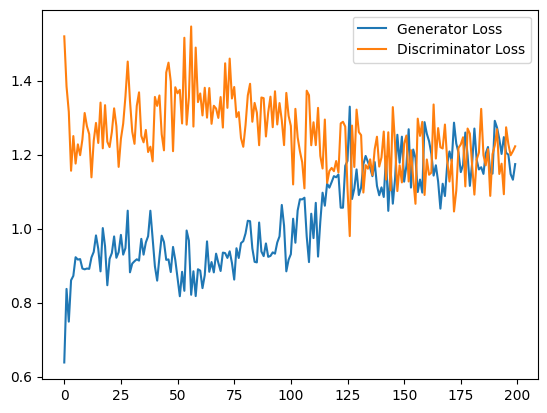

In [11]:
plt.plot(gen_losses, label='Generator Loss')
plt.plot(disc_losses, label='Discriminator Loss')
plt.legend()
plt.show()

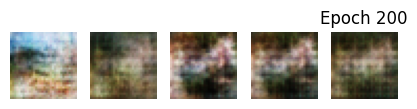

In [14]:
generate_images(generator, epoch=200, num_images=5, save=True)

## Analysis
The losses of both discriminator and generator show some initial convergence around each other, though there is still heavy oscillation.  Both models appear to be close to an equilibrium where both models will start improving.  Unfortunately, the generator seems to suffer from mode collapse as four of the five sample images generated look very similar to each other.  To fix this, we can increase the dropout rate and tune this as a hyperparameter.  Currently the model was hardcoded at a dropout rate of 0.3, but this could be increased and tuned to minimize mode collapse.  Additionally, more advanced architectures could be used such as the WGAN.

Altogether, after 200 epochs the models appear close to an equillibrium and show signs of improvement.  These models were trained with limited compute resources, and the generator is able to generate colorful, low quality images, so further training on the CIFAR-10 dataset would strengthen the model.